In [ ]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# import segmentation_models_pytorch as smp

In [7]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.io
import albumentations as album
import torch
import numpy as np

#from segmentation_models_pytorch import *

In [8]:
torch.__version__

'2.0.0+cu117'

In [9]:
import pandas as pd

In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


In [11]:
DATA_DIR = "data/Dataset"

x_train_dir = os.path.join(DATA_DIR, 'Train', 'Image')
y_train_dir = os.path.join(DATA_DIR, 'Train', 'Mask')

x_valid_dir = os.path.join(DATA_DIR, 'Val', 'Image')
y_valid_dir = os.path.join(DATA_DIR, 'Val', 'Mask')

x_test_dir = os.path.join(DATA_DIR, 'Test', 'Image')
y_test_dir = os.path.join(DATA_DIR, 'Test', 'Mask')

In [62]:
class Dataset(BaseDataset):

    def __init__(
            self,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)

        self.ids.sort()
        self.mask_ids.sort()

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]

        self.class_values = np.arange(0,6,1)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    @staticmethod
    def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

    def __getitem__(self, i):

        # read data
        im_id = self.images_fps[i].split('\\')[-1]
        image = self._read_img(self.images_fps[i])
        image = image[:,:,0:3]
        mask =  self._read_img(self.masks_fps[i])


        if self.augmentation is not None:
            transformed = self.augmentation(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        if self.preprocessing:
            preprocessed  = self.preprocessing(image=image, mask=mask)
            image,mask = preprocessed['image'], preprocessed['mask']

        mask_raw = convert_from_color(mask)
        masks = [(mask_raw == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)

        image = image.transpose(2, 0, 1).astype('float32')
        mask = mask.transpose(2, 0, 1).astype('float32')

        image_ = image / image.max()

        image = torch.as_tensor(image, dtype=torch.float32).cuda()
        mask = torch.as_tensor(mask, dtype=torch.float32).cuda()


        return image, mask_raw

    def __len__(self):
        return len(self.ids)

In [63]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.subplots_adjust(left=0.5, bottom=None, right=0.9, top=None, wspace=None, hspace=None)

        plt.imshow(image)
    plt.show()

for i in range(10):
    dataset = Dataset(x_train_dir, y_train_dir)

    image, mask = dataset[np.random.randint(len(dataset))] # get some sample
    image = image.detach().cpu().numpy()
    mask  = mask.detach().cpu().numpy()

    mask0 = np.transpose(mask, (1,2,0))

    mask1 = np.argmax(mask0, axis = 2)
    image = np.transpose(image, (1,2,0)).astype('uint8')
    mask = convert_to_color(mask1)

    visualize(
        map_patch = image,
        ground_truth_mask = mask)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
def get_training_augmentation():
    train_transform =     train_transform = [

        album.HorizontalFlip(p=0.5),

        album.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=256, width=256, always_apply=True),

        album.IAAAdditiveGaussianNoise(p=0.2),
        album.IAAPerspective(p=0.5),

        album.OneOf(
            [
                album.CLAHE(p=1),
                album.RandomBrightness(p=1),
                album.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        album.OneOf(
            [
                album.IAASharpen(p=1),
                album.Blur(blur_limit=3, p=1),
                album.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        album.OneOf(
            [
                album.RandomContrast(p=1),
                album.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """

    _transform = [
        album.Lambda(image=preprocessing_fn),
    ]
    return album.Compose(_transform)

In [ ]:
from mmseg.apis import inference_model, init_model, show_result_pyplot
import mmcv

config_file = 'configs/vit/vit_vit-b16_mln_upernet_8xb2-80k_roadseg-512x512.py'

# build the model from a config file and a checkpoint file
model = init_model(config_file, device='cuda:0')
log_path = "outputs"
experiment_log = r"timm-resnest200e"

c:\Users\canhu\Desktop\AI\Computer Vision\mmseg_new\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
c:\Users\canhu\Desktop\AI\Computer Vision\mmseg_new\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [ ]:
%pip install ipywidgets
%pip install pytorch-toolbelt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation= get_training_augmentation(),
    preprocessing= None,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation= get_validation_augmentation(),
    preprocessing= None,
)

c:\Users\canhu\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
c:\Users\canhu\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\imgaug\transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
c:\Users\canhu\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\canhu\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instea

In [20]:
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for mask in dataset.masks_fps:
      mask = fs.read_image_as_is(mask)
      unique_labels = np.unique(mask)
      labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

In [21]:
mul_factor =  5 #increases the total # of ims in a batch
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)
valid_sampler = WeightedRandomSampler(get_balanced_weights(valid_dataset), len(valid_dataset) * mul_factor)

In [22]:
list(train_sampler.weights)

[tensor(4.1275, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.10

In [23]:
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=8, sampler=valid_sampler)

In [ ]:
import segmentation_models_pytorch.utils.metrics

In [ ]:
loss = smp.utils.losses.DiceLoss(ignore_channels=[0])

In [ ]:
metrics = [smp.utils.metrics.Fscore(threshold=0.5,ignore_channels=[0]),
    smp.utils.metrics.Precision(threshold=0.5,ignore_channels=[0]),
    smp.utils.metrics.Recall(threshold=0.5,ignore_channels=[0])]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
#cengo eklemeler

In [ ]:
metrics = [smp.utils.metrics.Fscore(threshold=0.5,ignore_channels=[0]),
    smp.utils.metrics.Precision(threshold=0.5,ignore_channels=[0]),
    smp.utils.metrics.Recall(threshold=0.5,ignore_channels=[0]),
    smp.utils.metrics.IoU(threshold=0.5,ignore_channels=[0])]
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [24]:
from mmengine.evaluator import BaseMetric

class Accuracy(BaseMetric):
    def process(self, data_batch, data_samples):
        score, gt = data_samples
        # save the middle result of a batch to `self.results`
        self.results.append({
            'batch_size': len(gt),
            'correct': (score.argmax(dim=1) == gt).sum().cpu(),
        })

    def compute_metrics(self, results):
        total_correct = sum(item['correct'] for item in results)
        total_size = sum(item['batch_size'] for item in results)
        # return the dict containing the eval results
        # the key is the name of the metric name
        return dict(accuracy=100 * total_correct / total_size)

In [65]:
asd = train_dataset[32]

In [ ]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

In [75]:
from torch.optim import AdamW
from mmengine.runner import Runner

runner = Runner(
    # the model used for training and validation.
    # Needs to meet specific interface requirements
    model=model,
    # working directory which saves training logs and weight files
    work_dir='./work_dir',
    # train dataloader needs to meet the PyTorch data loader protocol
    train_dataloader=train_loader,
    # optimize wrapper for optimization with additional features like
    # AMP, gradtient accumulation, etc
    optim_wrapper=dict(optimizer=dict(type=AdamW, lr=0.0001)),
    # trainging coinfs for specifying training epoches, verification intervals, etc
    train_cfg=dict(by_epoch=True, max_epochs=5, val_interval=1),
    # validation dataloaer also needs to meet the PyTorch data loader protocol
    val_dataloader=valid_loader,
    # validation configs for specifying additional parameters required for validation
    val_cfg=dict(),
    # validation evaluator. The default one is used here
    val_evaluator=dict(type=Accuracy),
)

runner.train()

09/28 03:34:32 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 806870380
    GPU 0: NVIDIA GeForce GTX 1650 Ti with Max-Q Design
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.0
    NVCC: Cuda compilation tools, release 12.0, V12.0.140
    GCC: n/a
    PyTorch: 2.0.0+cu117
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch

TypeError: list indices must be integers or slices, not str

In [76]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

norm_cfg = dict(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201])
x_dataloader = DataLoader(batch_size=32,
                              shuffle=True,
                              dataset=torchvision.datasets.CIFAR10(
                                  'data/cifar10',
                                  train=True,
                                  download=True,
                                  transform=transforms.Compose([
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**norm_cfg)
                                  ])))

100%|██████████| 170498071/170498071 [05:51<00:00, 485405.43it/s]


Extracting data/cifar10\cifar-10-python.tar.gz to data/cifar10


In [77]:
a=next(iter(x_dataloader))

In [79]:
type(a), len(a)

(list, 2)

In [80]:
a[0].shape, a[1].shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [ ]:
log_path = "/content/drive/My Drive/Colab Notebooks/outputs"
experiment_log = r"timm_resnest_200e"

In [ ]:
# # Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
# TRAINING = True

# # Set num of epochs
# EPOCHS = 5

# # Set device: `cuda` or `cpu`
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # define loss function
# loss = smp.utils.losses.DiceLoss()

# # define metrics
# metrics = [
#     smp.utils.metrics.IoU(threshold=0.5),
# ]

# # define optimizer
# optimizer = torch.optim.Adam([
#     dict(params=model.parameters(), lr=0.00008),
# ])

# # define learning rate scheduler (not used in this NB)
# #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
# #    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
# #)

# # load best saved model checkpoint from previous commit (if present)
# #if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
# #   model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
# %%time

# if TRAINING:

#     best_iou_score = 0.0
#     train_logs_list, valid_logs_list = [], []

#     for i in range(0, EPOCHS):

#         # Perform training & validation
#         print('\nEpoch: {}'.format(i))
#         train_logs = train_epoch.run(train_loader)
#         valid_logs = valid_epoch.run(valid_loader)
#         train_logs_list.append(train_logs)
#         valid_logs_list.append(valid_logs)

#         # Save model if a better val IoU score is obtained
#         if best_iou_score < valid_logs['iou_score']:
#             best_iou_score = valid_logs['iou_score']
#             torch.save(model, './best_model.pth')
#             print('Model saved!')

In [ ]:
# if os.path.exists('./best_model.pth'):
#     best_model = torch.load('./best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from this run.')


In [ ]:
!pip install pytorch-toolbelt

In [ ]:
# #import segmentation_models_pytorch
# from segmentation_models_pytorch import *

In [ ]:
best_model = torch.load(os.path.join(log_path,'{}.pth'.format(experiment_log)))

ModuleNotFoundError: ignored

In [ ]:
#best_model.cuda()

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s, dice_loss - 0.1846, iou_score - 0.9215]


In [ ]:
logs

In [ ]:
logs

In [ ]:
def visualize_nd_dwn(idx, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        #save_dir = os.path.join(r'C:\Users\BURAK\Desktop\inf\2\New folder', '.\{}.png'.format(idx))
        #plt.savefig(save_dir, pad_inches = 0, transparent=False, bbox_inches='tight')

    plt.show()

<ipython-input-31-15df8045ed26>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
<ipython-input-31-15df8045ed26>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor, device = 'cuda')


(256, 256)


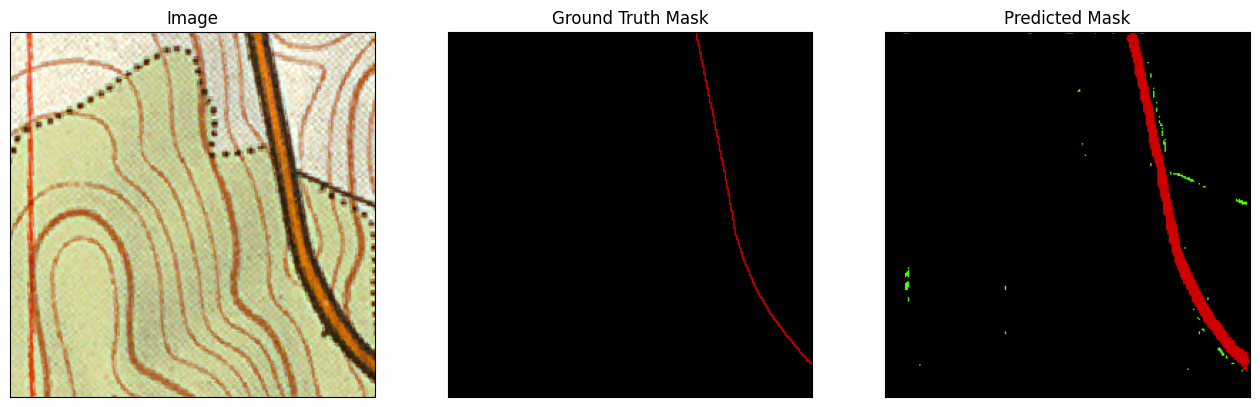

(256, 256)


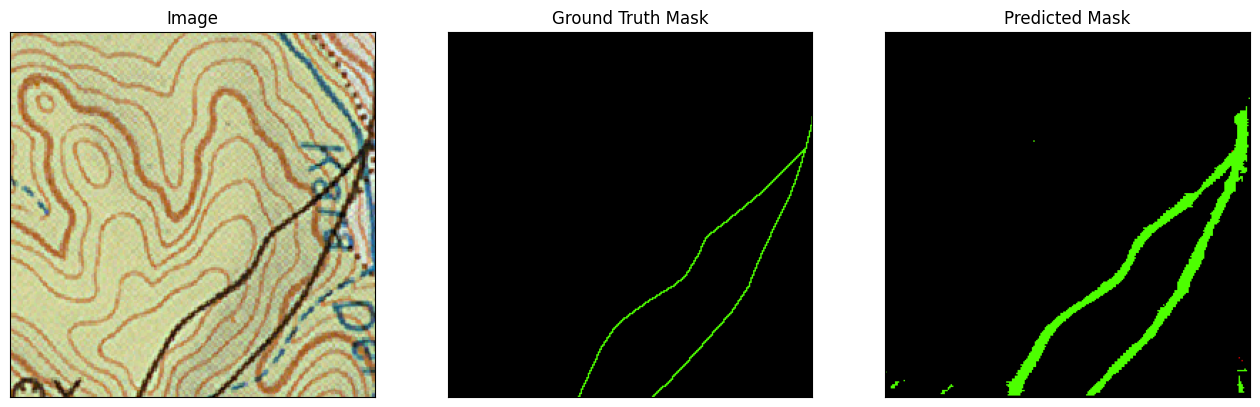

(256, 256)


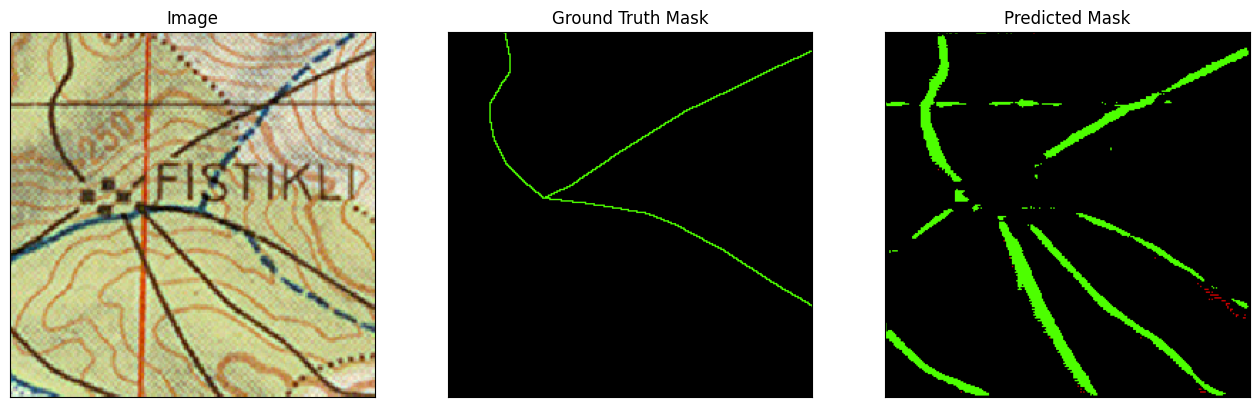

(256, 256)


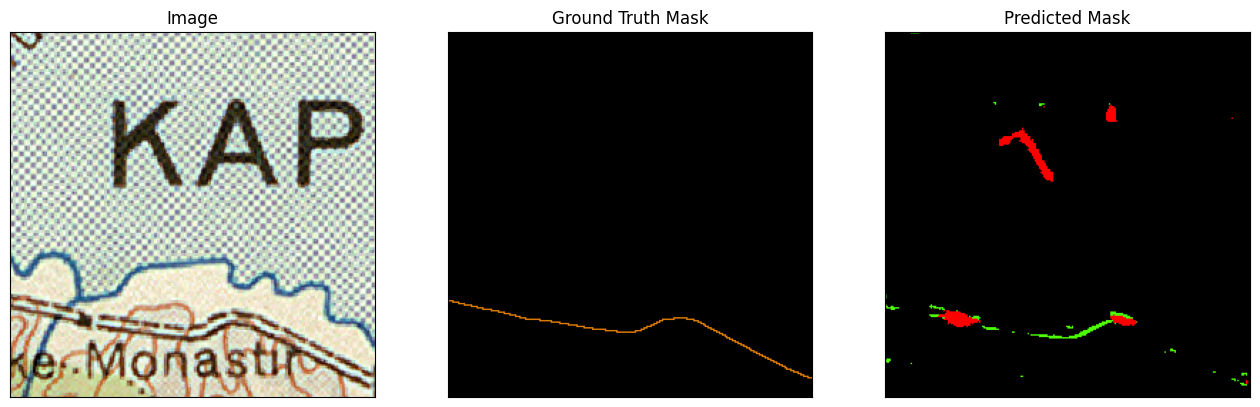

(256, 256)


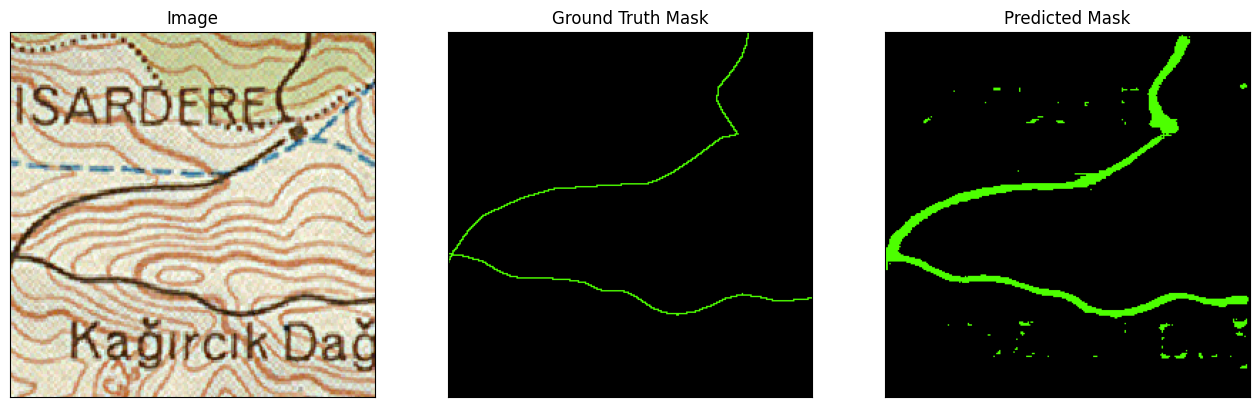

(256, 256)


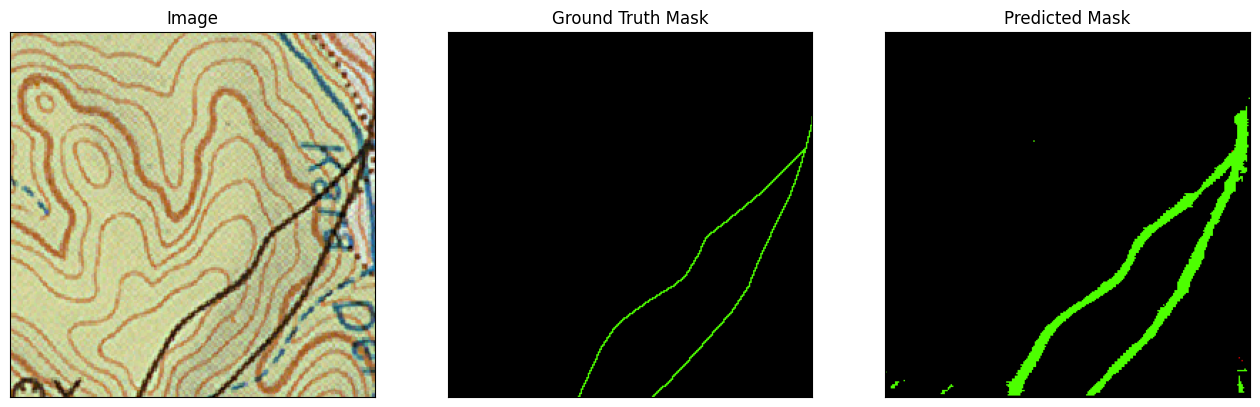

(256, 256)


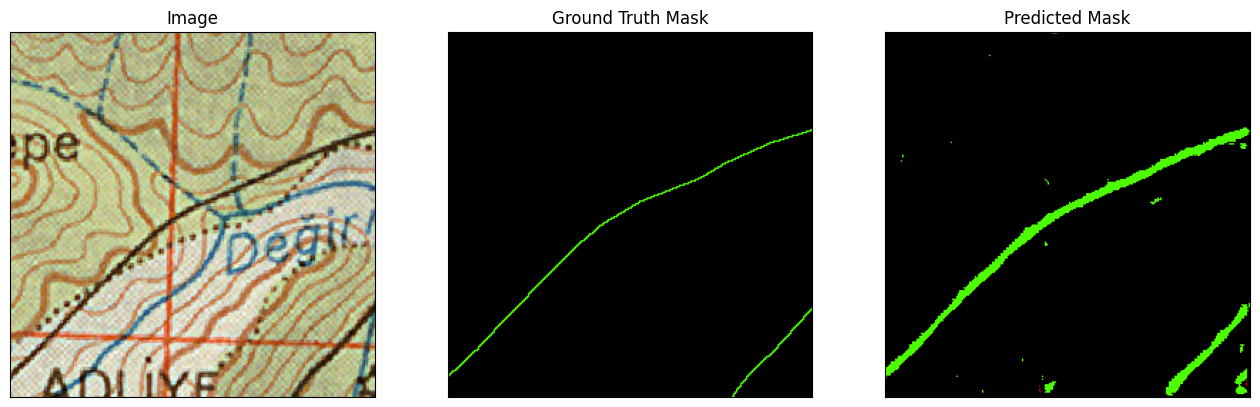

(256, 256)


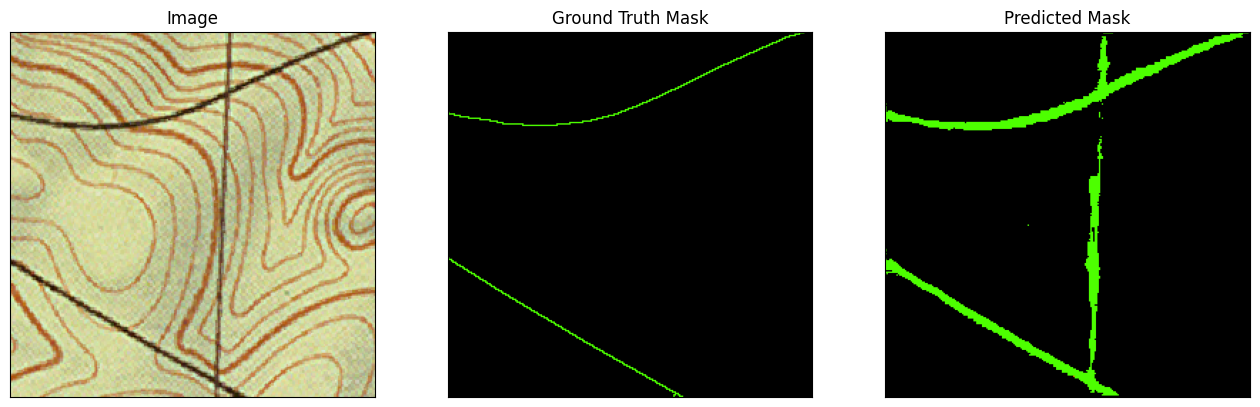

(256, 256)


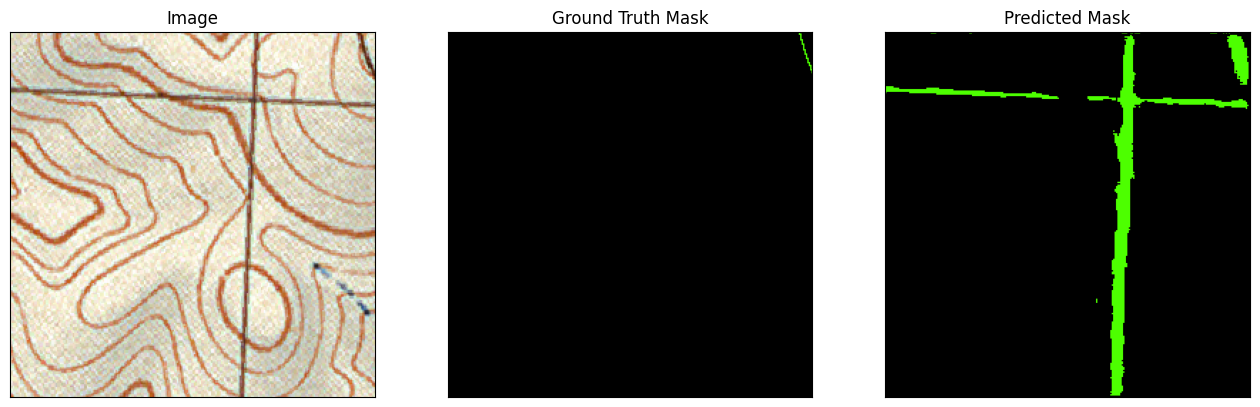

(256, 256)


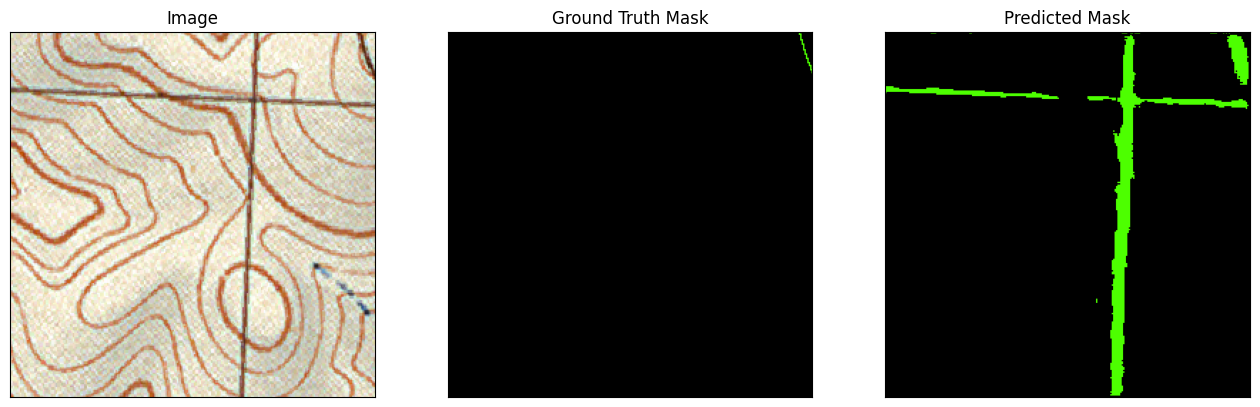

In [ ]:
for idx,i in enumerate(range(10)):  #len(test_dataset))):

    i = np.random.randint(0, len(test_dataset))
    image = np.transpose(test_dataset[i][0].detach().cpu().numpy(),(1,2,0))

    gt_mask = np.transpose(test_dataset[i][1].detach().cpu().numpy() ,(1,2,0))

    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)

    x_tensor = test_dataset[i][0]
    tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
    tensor = tensor.float()
    tensor = torch.tensor(tensor, device = 'cuda')

    pr_mask = best_model.predict(tensor).detach().cpu().numpy()
    pr_mask = pr_mask.squeeze()
    pr_max  = np.argmax(pr_mask.squeeze(), 0)
    print(pr_max.shape)

    pr_max11 = convert_to_color(pr_max)

    visualize_nd_dwn(idx = idx,
                     image=image.astype('uint8'),  #ımage torch.Size([512, 512, 4])
            ground_truth_mask=gt_color,  #gt_color (512, 512, 3)
            predicted_mask=pr_max11) #pr_max11 (512, 512, 3)
    #save_dir = os.path.join(r'C:\Users\BURAK\Desktop\inf\2\New folder', '.\{}.png'.format(idx))


In [ ]:
import tqdm

def evaluate(model, generator):
    """ usage:
        from sklearn.metrics import classification_report
        y_pred, y = evaluate(best_model, generator)
        y_pred  = np.hstack(y_pred)
        y = np.hstack(y)
        targets = ['building', 'not_building']
        print(classification_report(y, y_pred, target_names = targets))#, output_dict = True)
    """

    best_model = model
    best_model.cuda()
    best_model.eval()

    y_preds = list()
    ys = list()
    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(generator))):
            X,y = generator[idx]
            #X = X.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            gt_max = np.argmax(y, axis=0)
            #gt_colora = convert_to_color(gt_max)
            logsoftmax = best_model.forward(X[None,:,:])
            y_pred = logsoftmax.argmax(dim=1)
            y_pred = y_pred.squeeze()
            gt_color = torch.as_tensor(gt_max).cuda()
            gt_color = gt_color.detach().cpu().numpy().flatten()
            y= gt_color
            y_pred = y_pred.flatten().detach().cpu().numpy()

            ys.append(y)
            y_preds.append(y_pred)

    best_model.cpu()
    return y_preds, ys

In [ ]:
y_preds, ys = evaluate(best_model, test_dataset)

100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


In [ ]:
y_preds = np.asarray(y_preds)
ys = np.asarray(ys)

In [ ]:
np.unique(y_preds), y_preds.shape

(array([0, 1, 2, 3, 4, 5]), (50, 65536))

In [ ]:
np.unique(ys), ys.shape

(array([0, 1, 2, 3, 4, 5]), (50, 65536))

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score



In [ ]:
include_label = [1,2,3,4,5]

In [ ]:
F1 = f1_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)
Precision = precision_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)
Recall = recall_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)
IOU = jaccard_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)

In [ ]:
f1 = np.asarray(F1)
prec = np.asarray(Precision)
rec = np.asarray(Recall)
iou = np.asarray(IOU)


metrics = np.stack((f1, prec, rec, iou), axis = 1)
metrics

array([[2.11308784e-01, 1.20685625e-01, 8.48298122e-01, 1.18135977e-01],
       [2.17026734e-01, 1.21829660e-01, 9.92779783e-01, 1.21721810e-01],
       [1.87969925e-03, 2.50000000e-01, 9.43396226e-04, 9.40733772e-04],
       [2.20516836e-01, 1.26142268e-01, 8.75621891e-01, 1.23921845e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
f1[:-1].mean()

0.16268301337992264

In [ ]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(ys.flatten(), y_preds.flatten(), average=None)

In [ ]:
f1[:-1].mean(),prec[:-1].mean(),rec[:-1].mean(),jaccard[:-1].mean()

(0.16268301337992264,
 0.15466438824703924,
 0.6794107980582271,
 0.26552108712559025)

In [ ]:
f1 = np.asarray(F1)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, prec, rec), axis = 1)
metrics

array([[2.11308784e-01, 1.20685625e-01, 8.48298122e-01],
       [2.17026734e-01, 1.21829660e-01, 9.92779783e-01],
       [1.87969925e-03, 2.50000000e-01, 9.43396226e-04],
       [2.20516836e-01, 1.26142268e-01, 8.75621891e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
f1

In [ ]:
prec

In [ ]:
rec

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(ys.flatten(), y_preds.flatten())

In [ ]:
acc

In [ ]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(ys.flatten(), y_preds.flatten(), average=None)

In [ ]:
jaccard

In [ ]:
f1.mean()

0.13014641070393812

In [ ]:
prec.mean()

0.12373151059763139

In [ ]:
rec.mean()

0.5435286384465817

In [ ]:
jaccard.mean()

0.22126757260465854

In [ ]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

tr_Class_names = ['Şose', 'Demiryolu', 'Patika', 'Araba Yolu', 'Adi Yol']

In [ ]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']

In [ ]:
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


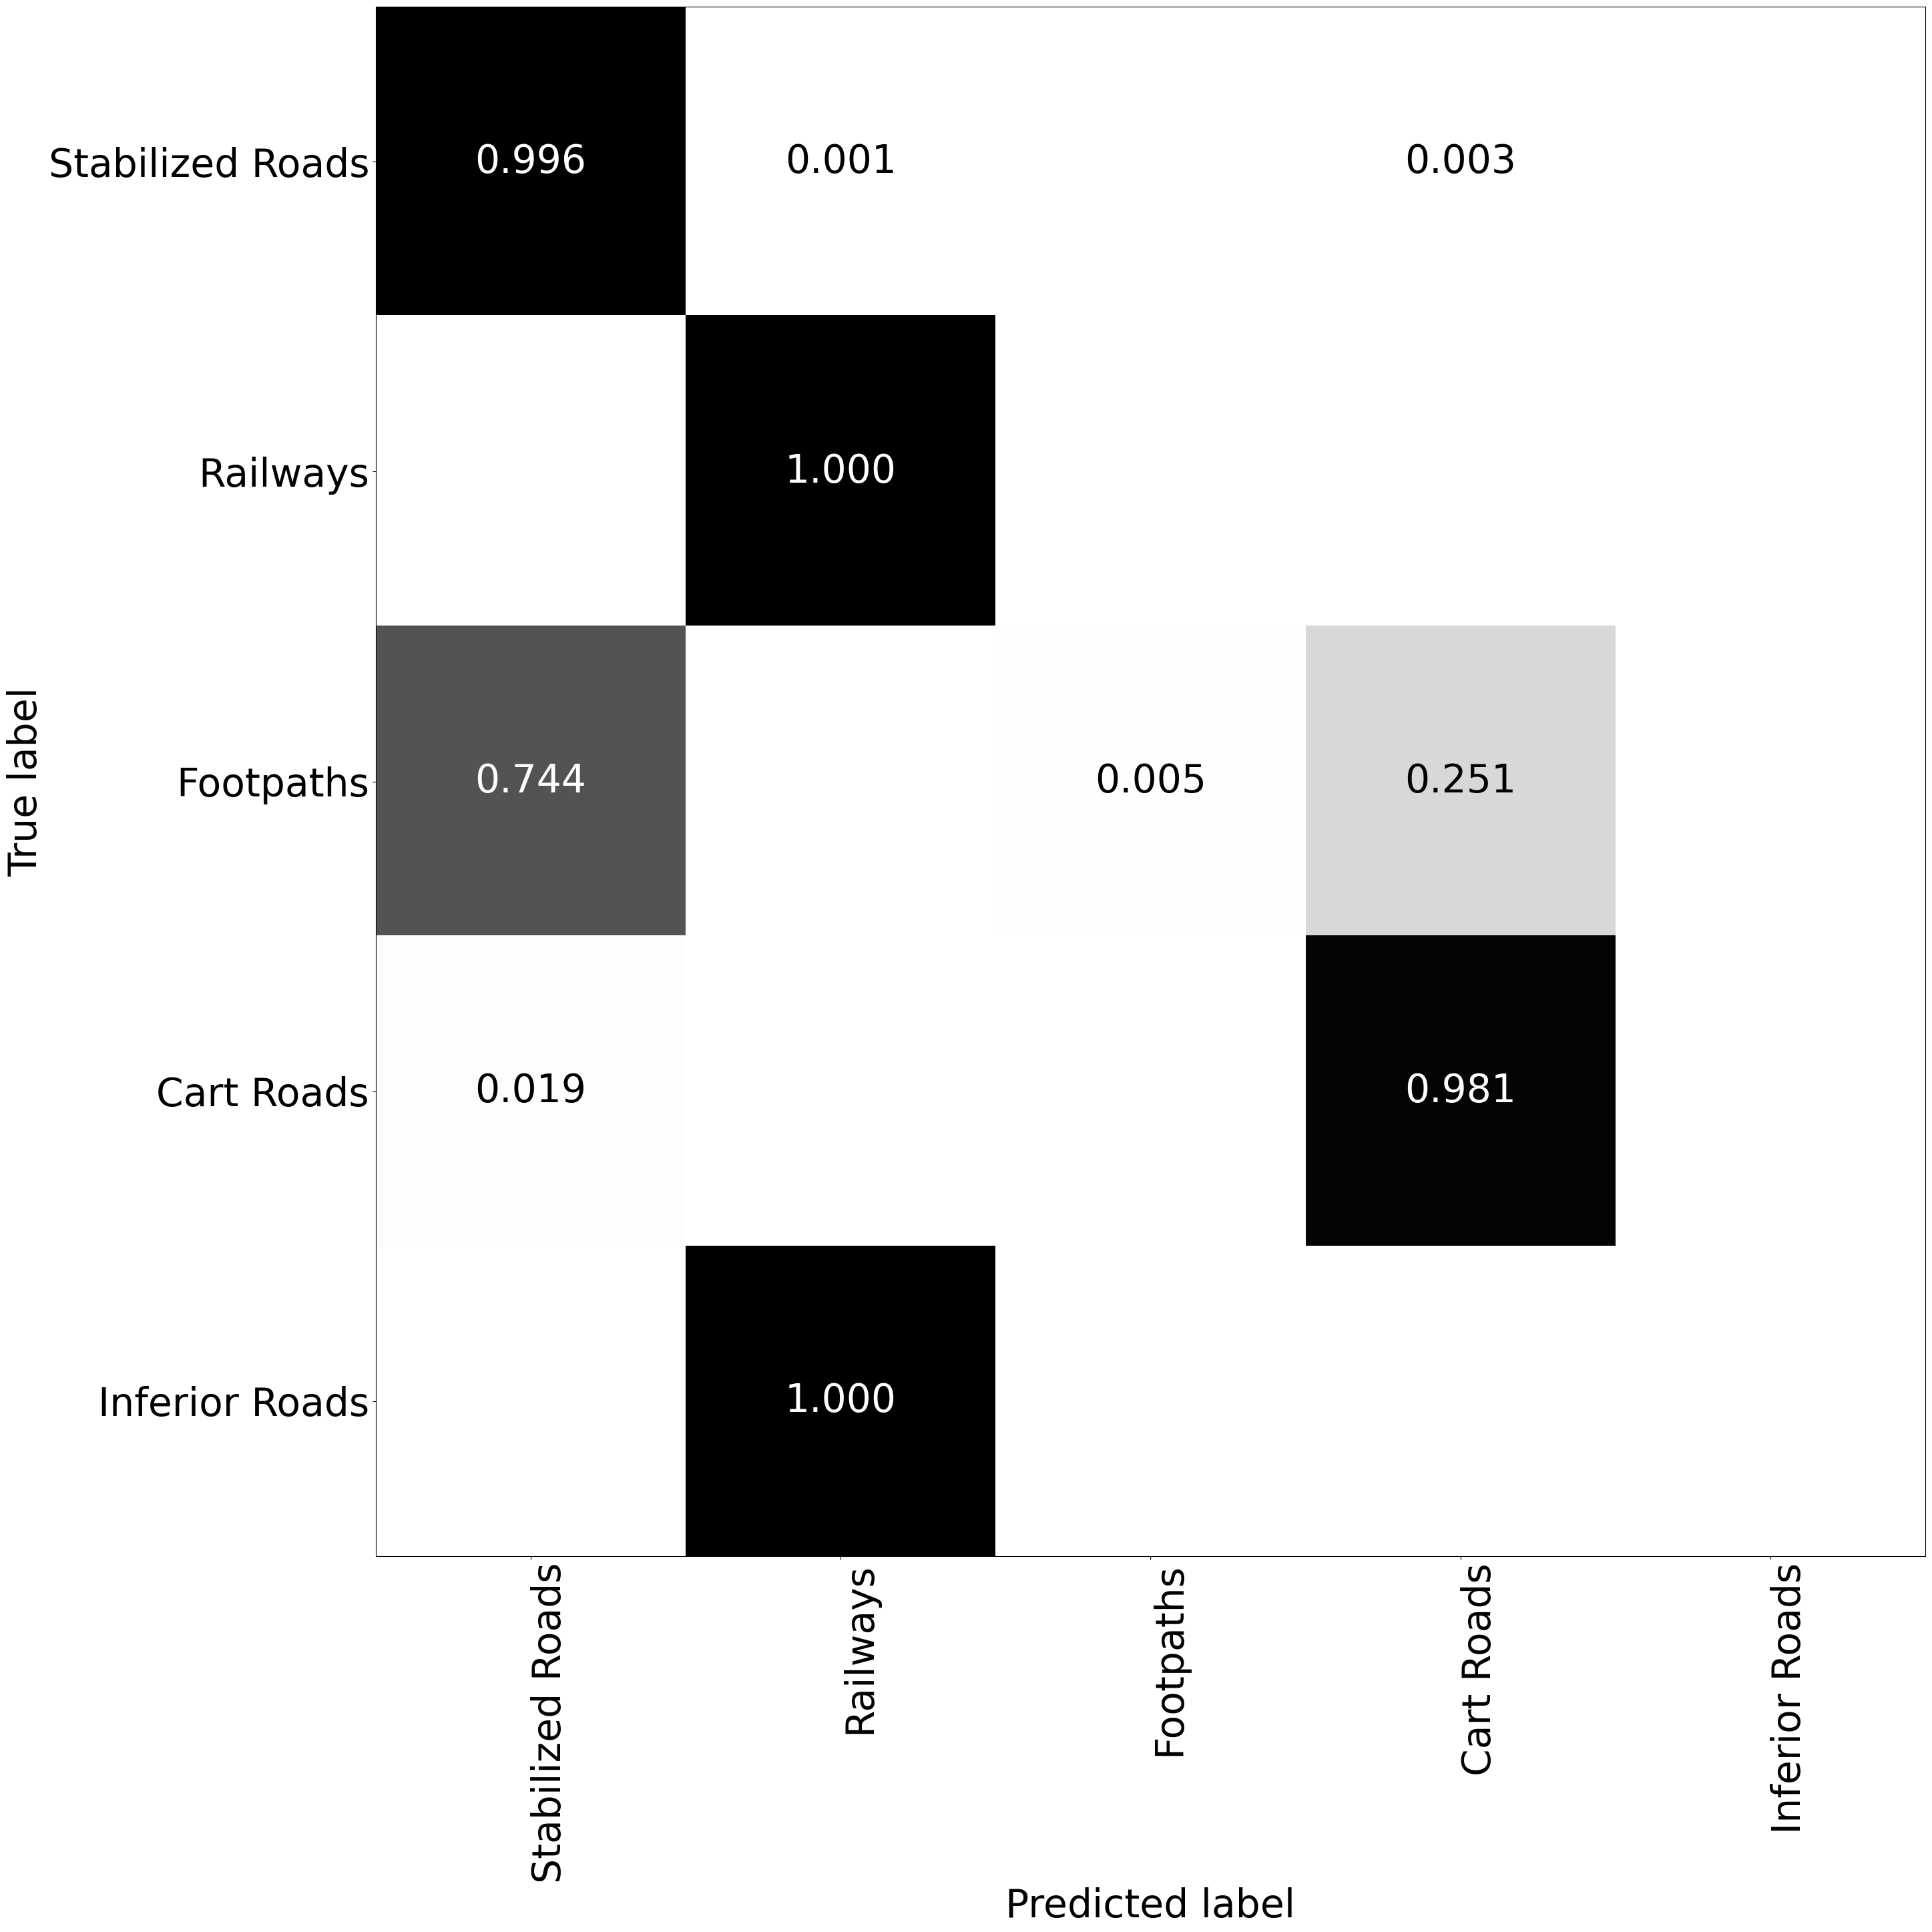

In [ ]:
cm=plot_confusion_matrix(ys=ys,
                      y_preds=y_preds,
                      classes=ing_Class_names,
                      normalize=True)

Confusion matrix, without normalization


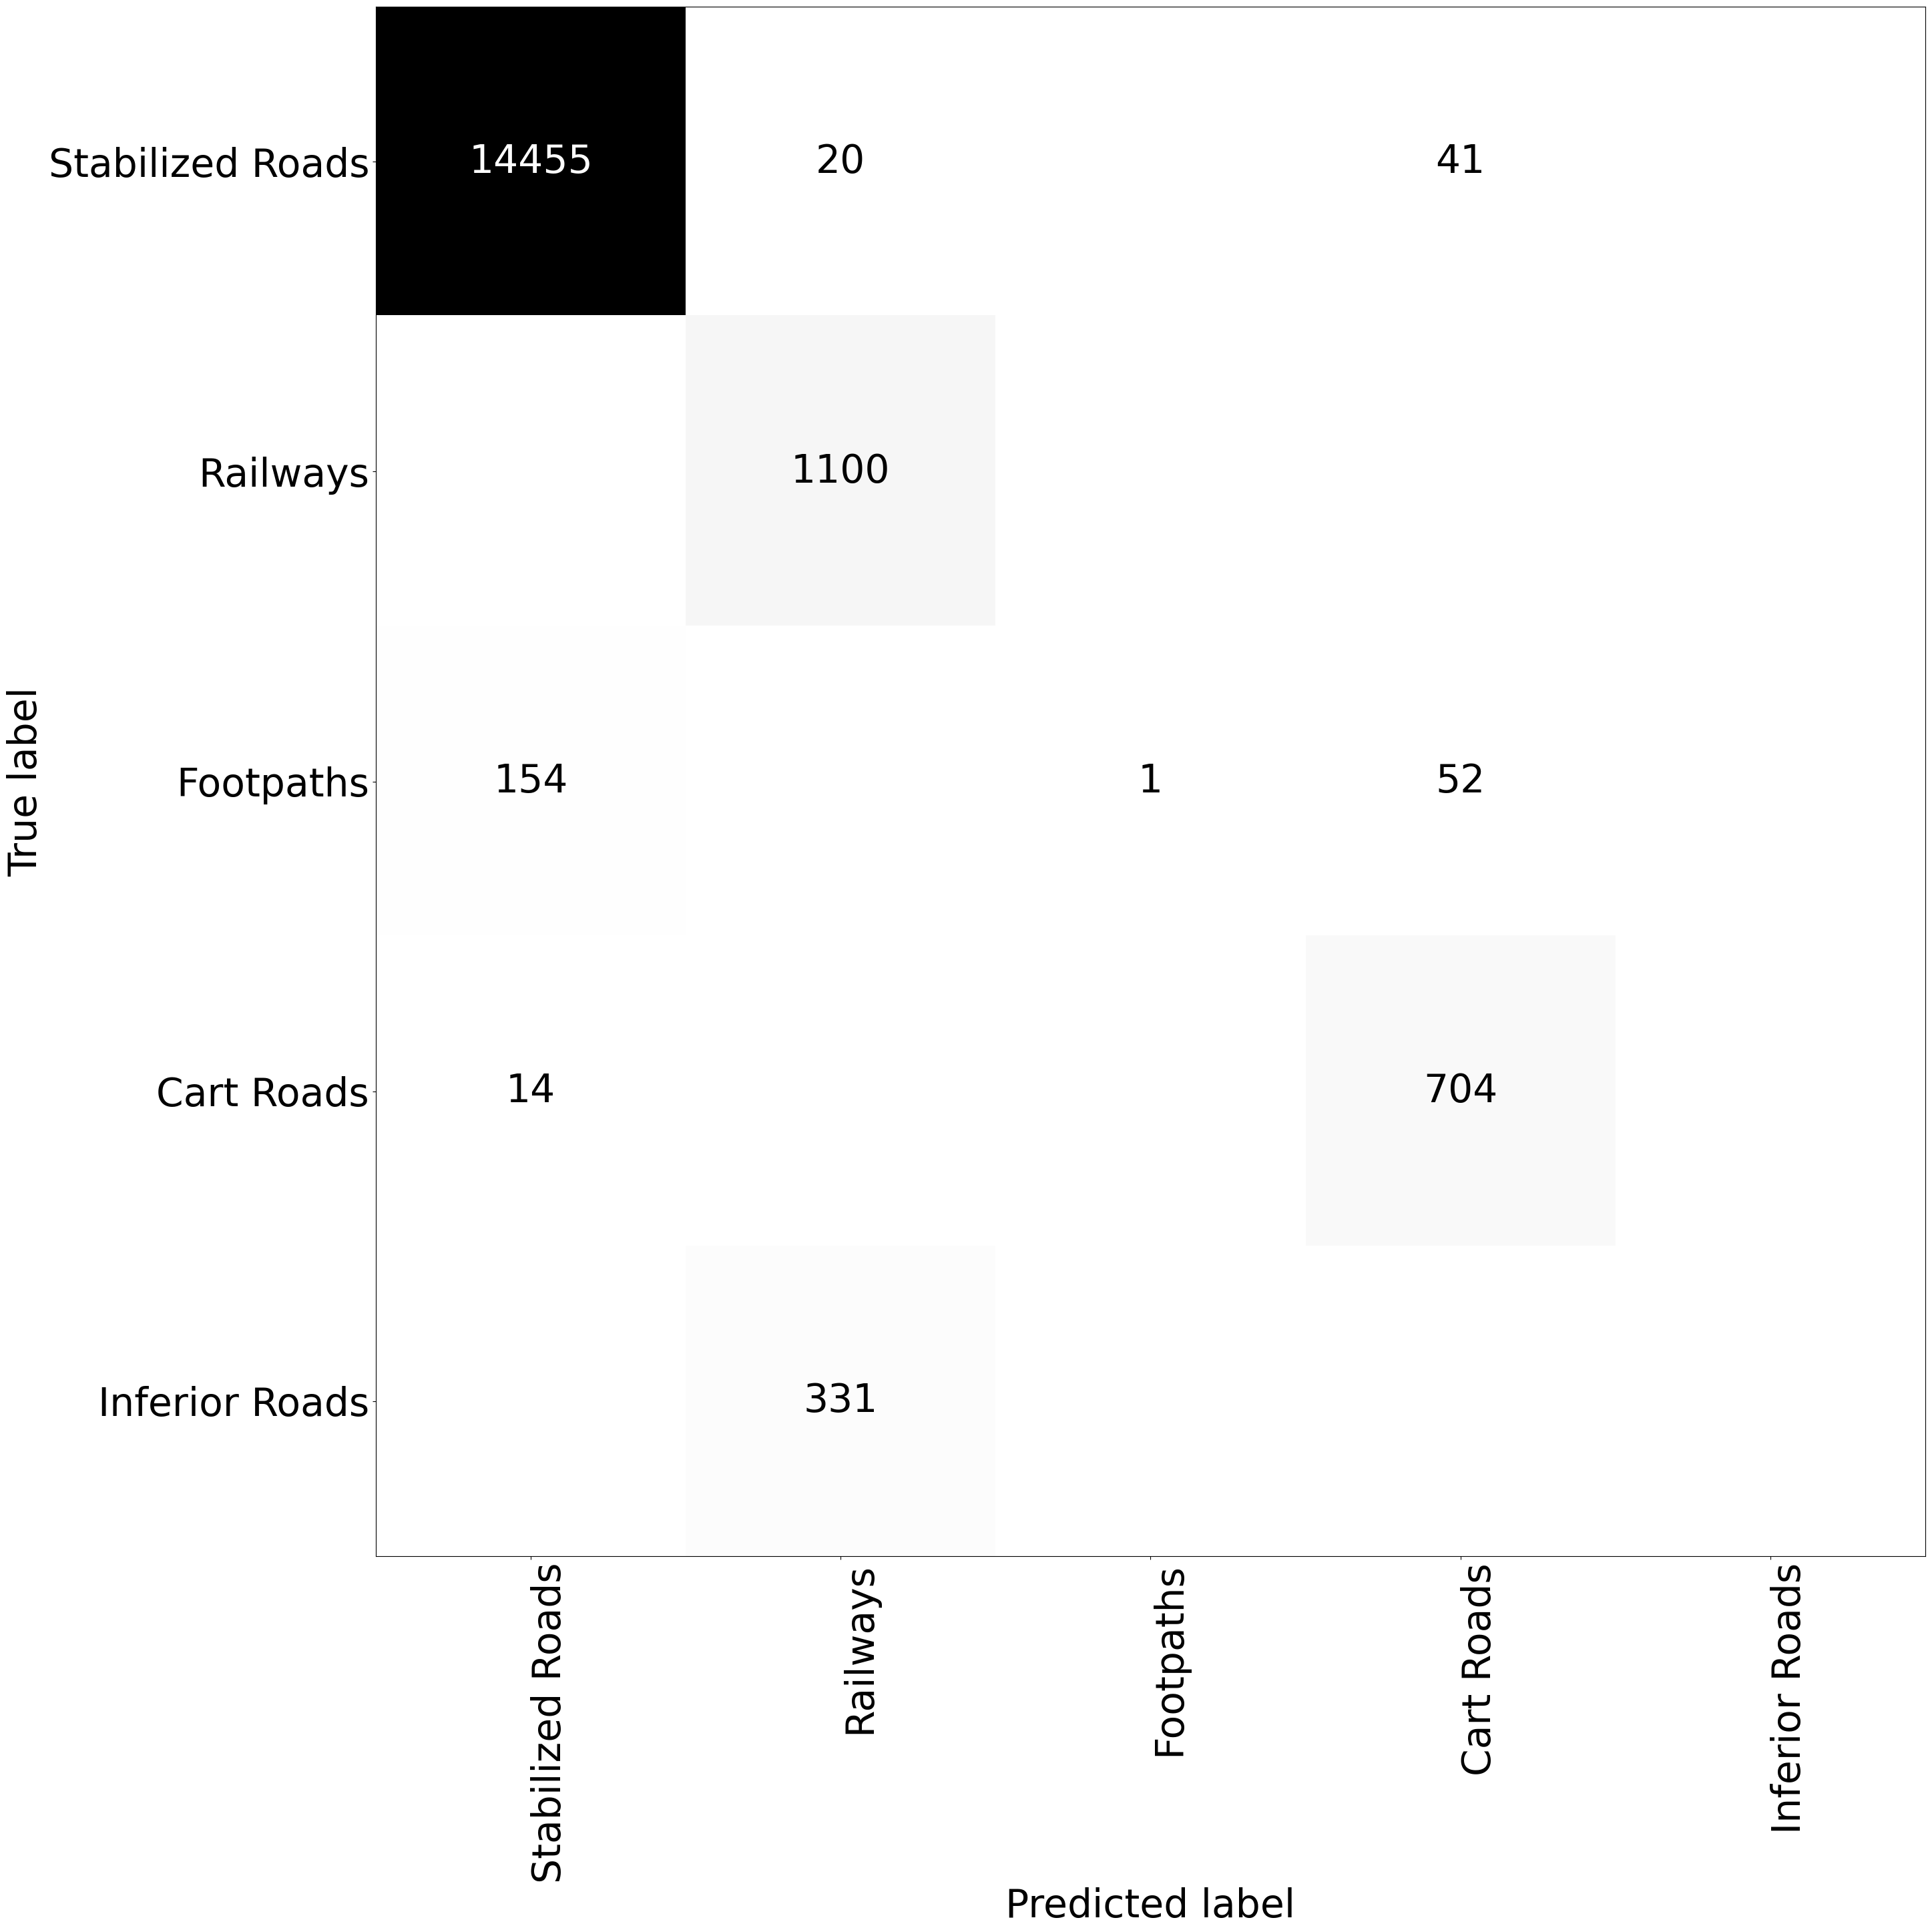

In [ ]:
cm1=plot_confusion_matrix(ys=ys,
                      y_preds=y_preds,
                      classes=ing_Class_names,
                      normalize=False)

In [ ]:
cm1.print_stats()

AttributeError: ignored

In [ ]:
FP = cm1.sum(axis=0) - np.diag(cm1)
FN = cm1.sum(axis=1) - np.diag(cm1)
TP = np.diag(cm1)
TN = cm1.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

AttributeError: ignored

## Viz

In [ ]:
import numpy as np
import matplotlib.patches
from matplotlib import pyplot as plt
import os

colors = [(75, 255, 0),(204, 0, 0), (230, 128, 0), (255, 0, 0), (0, 204, 242)]
clrs = np.asarray(colors) / 255

labels = ['Stabilized/Macadam Roads (Fahrstraße)', 'Railways (Eísenbahn)', 'Footpaths (Fußweg)', 'Cart Roads (Karawanenweg)', 'Inferior Roads (Saumweg)']

viz_dir = r"C:\Users\cagat\Desktop"

In [ ]:
# Create a color palette
palette = dict(zip(labels, clrs))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
params = {'font.size': 36}
matplotlib.rcParams.update(params)

plt.legend(handles=handles)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.savefig(os.path.join(viz_dir,'LEGEND.png'), pad_inches = 0, transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

In [ ]:
F1 = [0.58494453, 0.51084298, 0.55573352, 0.57194202, 0.51975535]
Prec = [0.50699633, 0.42357872, 0.47470608, 0.49331049 , 0.43727488]
Rec = [0.69121554, 0.64339255, 0.6701153, 0.68039381, 0.64058495]
IOU = [0.41337216, 0.34304172,0.384786 , 0.40050336, 0.35112801]

F1 = np.asarray(F1)
Prec = np.asarray(Prec)
Rec = np.asarray(Rec)
IOU = np.asarray(IOU)

In [ ]:
array([[0.58494453, 0.50699633, 0.69121554, 0.41337216],
       [0.51084298, 0.42357872, 0.64339255, 0.34304172],
       [0.55573352, 0.47470608, 0.6701153 , 0.384786  ],
       [0.57194202, 0.49331049, 0.68039381, 0.40050336],
       [0.51975535, 0.43727488, 0.64058495, 0.35112801]])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ing_Class_names

F1_ = F1 * 100
Prec_ = Prec * 100
Recall_ = Rec * 100
IOU_ = IOU * 100

params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
matplotlib.rcParams.update(params)

x = np.arange(len(labels))  # the label locations
width = 0.20 # the width of the bars

fig, ax = plt.subplots(figsize=(30, 30))
rects1 = ax.bar(x - width, F1_, width, label='F1')
rects2 = ax.bar(x, Prec_, width, label='Precision')
rects3 = ax.bar(x + width, Recall_, width, label='Recall')
rects4 = ax.bar(x - (2 * width), IOU_, width, label='IOU')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_title('F1 Score Comparison')
ax.set_ylabel('Scores')
ax.set_xlabel('Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

ax.legend(loc='best', bbox_to_anchor=(-0.04, 0.5, 0., 0.5))
#ax.set_yticks(np.arange(60,10,20))

ax.set_ylim([0,80])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height == 0:
            continue
        else:
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation = 90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
plt.savefig(r'C:\Users\cagat\Desktop\F1_score.png', pad_inches = 0, transparent=False, bbox_inches='tight')

fig.tight_layout()

plt.show()

## geo-export

In [ ]:
#eğer bu line çalışmışsa koşturma bitmiştir.

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('fscore', fontsize=20)
plt.title('fscore Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('fscore_score_plot.png')
plt.show()

In [ ]:
train_logs_df.T

In [ ]:
train_logs_list[0]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_list_1 =  [0.4006,
0.4863,
0.5097,
0.5246,
0.5362,
0.5463,
0.5537,
0.5733,
0.5844,
0.5906,
0.5926,
0.5944,
0.5963,
0.5949,
0.5959

]
valid_list_1 = [
0.4618,
0.4694,
0.4849,
0.5017,
0.464,
0.4877,
0.4882,
0.5024,
0.4951,
0.4929,
0.5,
0.4881,
0.5002,
0.4924,
0.5031]
list(np.float_(train_list_1))
list(np.float_(valid_list_1))

In [ ]:
a2_train_list_1 =  [0.3933,
0.4726,
0.4958,
0.51,
0.5213,
0.5444,
0.55,
0.5552,
0.5603,
0.5636,
0.5657,
0.5685,
0.5704,
0.5731,
0.5734]
a2_valid_list_1 = [
0.4425,
0.4509,
0.456,
0.4668,
0.4631,
0.4638,
0.4613,
0.4611,
0.4579,
0.4566,
0.4589,
0.4574,
0.454,
0.4569,
0.4499]
list(np.float_(a2_train_list_1))
list(np.float_(a2_valid_list_1))

In [ ]:
a2_train_logs_df = pd.DataFrame(a2_train_list_1)
a2_valid_logs_df = pd.DataFrame(a2_valid_list_1)
a2_train_logs_df.columns =['fscore']
a2_valid_logs_df.columns =['fscore']

In [ ]:
train_logs_df = pd.DataFrame(train_list_1)
valid_logs_df = pd.DataFrame(valid_list_1)

In [ ]:
train_logs_df.columns =['fscore']
valid_logs_df.columns =['fscore']

In [ ]:
train_logs_df

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train timm-resnest200e',color='blue')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid timm-resnest200e',color='blue',linestyle='--')
plt.plot(a2_train_logs_df.index.tolist(), a2_train_logs_df.fscore.tolist(), lw=3, label = 'Train resnext50_32x4d',color='red')
plt.plot(a2_valid_logs_df.index.tolist(), a2_valid_logs_df.fscore.tolist(), lw=3, label = 'Valid resnext50_32x4d',color='red',linestyle='--')

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('', fontsize=30)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
